In [105]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

In [106]:
# 只用抖音数据
df = pd.read_csv("../processed_data/processed_psi_douyin.csv")
print(f"抖音数据: {len(df)} 行, {len(df.columns)} 列")
print(f"\nSessions ({df['source_file'].nunique()} 个):")
print(df.groupby('source_file').size())

抖音数据: 4683 行, 46 列

Sessions (4 个):
source_file
psi_douyin_20260228_211328.csv     997
psi_douyin_20260228_213146.csv    1241
psi_douyin_20260228_215103.csv    1220
psi_douyin_20260228_221442.csv    1225
dtype: int64


In [107]:
# Lag 特征已在 data_process 中按 session 分组计算完成，这里不再重复
# 确认没有 phase / ts 列泄漏
for col in ['phase', 'ts']:
    assert col not in df.columns, f"发现泄漏列: {col}"
print("✓ 无 phase/ts 泄漏")
print(f"当前列: {df.columns.tolist()}")

✓ 无 phase/ts 泄漏
当前列: ['some_delta', 'full_delta', 'mem_available', 'pgscan_direct', 'pgsteal_direct', 'pgmajfault', 'workingset_refault', 'allocstall', 'pswpin', 'pswpout', 'source_file', 'future_1s_some', 'future_1s_full', 'some_sum_2', 'pgscan_sum_2', 'pgmaj_sum_2', 'some_max_2', 'some_min_2', 'some_sum_6', 'pgscan_sum_6', 'pgmaj_sum_6', 'some_max_6', 'some_min_6', 'some_sum_10', 'pgscan_sum_10', 'pgmaj_sum_10', 'some_max_10', 'some_min_10', 'diff_some', 'diff_pgscan', 'mem_drop', 'some_std_6', 'pgscan_std_6', 'some_lag_1', 'pgscan_lag_1', 'some_lag_2', 'pgscan_lag_2', 'some_lag_3', 'pgscan_lag_3', 'some_lag_4', 'pgscan_lag_4', 'some_ewm_6', 'pgscan_ewm_6', 'pgscan_per_mem', 'alloc_per_mem', 'swap_ratio']


In [108]:
# Session-aware 分割：最后一个 session 作为测试集
# 这样测试集完全是模型"没见过的会话"，更能评估真实泛化能力
sessions = df['source_file'].unique()
test_session = sessions[-1]
print(f"Test session: {test_session}")

train = df[df['source_file'] != test_session].reset_index(drop=True)
test  = df[df['source_file'] == test_session].reset_index(drop=True)
print(f"Train: {len(train)} 行 ({len(train)/len(df)*100:.1f}%)")
print(f"Test:  {len(test)} 行 ({len(test)/len(df)*100:.1f}%)")

Test session: psi_douyin_20260228_221442.csv
Train: 3458 行 (73.8%)
Test:  1225 行 (26.2%)


In [109]:
# 构建特征列（排除目标列和标识列）
drop_cols = ["source_file", "future_1s_some", "future_1s_full"]
feature_cols = [c for c in df.columns if c not in drop_cols]
print(f"特征数量: {len(feature_cols)}")
print(f"特征: {feature_cols}")

特征数量: 43
特征: ['some_delta', 'full_delta', 'mem_available', 'pgscan_direct', 'pgsteal_direct', 'pgmajfault', 'workingset_refault', 'allocstall', 'pswpin', 'pswpout', 'some_sum_2', 'pgscan_sum_2', 'pgmaj_sum_2', 'some_max_2', 'some_min_2', 'some_sum_6', 'pgscan_sum_6', 'pgmaj_sum_6', 'some_max_6', 'some_min_6', 'some_sum_10', 'pgscan_sum_10', 'pgmaj_sum_10', 'some_max_10', 'some_min_10', 'diff_some', 'diff_pgscan', 'mem_drop', 'some_std_6', 'pgscan_std_6', 'some_lag_1', 'pgscan_lag_1', 'some_lag_2', 'pgscan_lag_2', 'some_lag_3', 'pgscan_lag_3', 'some_lag_4', 'pgscan_lag_4', 'some_ewm_6', 'pgscan_ewm_6', 'pgscan_per_mem', 'alloc_per_mem', 'swap_ratio']


In [110]:
# 构造训练数据（log1p 变换缩小右偏目标的尺度差异）
X_train = train[feature_cols]
y_train = np.log1p(train["future_1s_some"])

X_test = test[feature_cols]
y_test = np.log1p(test["future_1s_some"])

print(f"X_train: {X_train.shape}, y_train range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"X_test:  {X_test.shape}, y_test range:  [{y_test.min():.2f}, {y_test.max():.2f}]")

X_train: (3458, 43), y_train range: [0.00, 13.43]
X_test:  (1225, 43), y_test range:  [1.39, 12.95]


In [111]:
# 非对称 MSE：低估惩罚是高估的 5 倍（从 100 降到 5，避免过度高估）
def asymmetric_mse_objective(y_true, y_pred):
    residual = y_pred - y_true
    penalty_factor = 5.0
    weights = np.where(residual < 0, penalty_factor, 1.0)
    grad = weights * residual
    hess = weights
    return grad, hess

In [112]:
# 训练 XGBoost（加入正则化 + early stopping 防过拟合）
model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=4,            # 从 6 降到 4，减少过拟合
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,          # L1 正则
    reg_lambda=1.0,         # L2 正则
    min_child_weight=5,     # 叶子节点最小样本权重
    random_state=42,
    objective=asymmetric_mse_objective,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

print(f"\n最优迭代次数: {model.best_iteration}")
print(f"最优 RMSE: {model.best_score:.4f}")

[0]	validation_0-rmse:7.74802	validation_1-rmse:7.61316


[50]	validation_0-rmse:1.64096	validation_1-rmse:1.81890
[100]	validation_0-rmse:1.68291	validation_1-rmse:2.03487

最优迭代次数: 50
最优 RMSE: 1.8189


In [113]:
# 预测 & 反变换回真实尺度
pred_log = model.predict(X_test)
pred_real = np.expm1(pred_log)
y_real = np.expm1(y_test)

In [114]:
# 评估（log 尺度 + real 尺度 + 分类视角）
print("=== Log 尺度 ===")
print(f"  R2:  {r2_score(y_test, pred_log):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, pred_log):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, pred_log)):.4f}")

print("\n=== Real 尺度 ===")
print(f"  R2:  {r2_score(y_real, pred_real):.4f}")
print(f"  MAE: {mean_absolute_error(y_real, pred_real):.0f} μs")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_real, pred_real)):.0f} μs")

print("\n=== Spike 检测（分类视角）===")
print(f"  future_1s_some 分布: mean={y_real.mean():.0f}, median={y_real.median():.0f}, "
      f"90th={y_real.quantile(0.9):.0f}, 95th={y_real.quantile(0.95):.0f}")

for q, label in [(0.75, "75th"), (0.90, "90th"), (0.95, "95th")]:
    thr = y_real.quantile(q)
    y_cls = (y_real > thr).astype(int)
    pred_cls = (pred_real > thr).astype(int)
    pos_rate = y_cls.mean()
    print(f"\n  阈值={thr:.0f} ({label}, 正样本率={pos_rate:.2%}):")
    print(f"    Accuracy:  {accuracy_score(y_cls, pred_cls):.4f}")
    print(f"    Precision: {precision_score(y_cls, pred_cls, zero_division=0):.4f}")
    print(f"    Recall:    {recall_score(y_cls, pred_cls, zero_division=0):.4f}")
    print(f"    F1:        {f1_score(y_cls, pred_cls, zero_division=0):.4f}")

=== Log 尺度 ===
  R2:  0.3948
  MAE: 1.4143
  RMSE: 1.8189

=== Real 尺度 ===
  R2:  0.1031
  MAE: 21197 μs
  RMSE: 52925 μs

=== Spike 检测（分类视角）===
  future_1s_some 分布: mean=25987, median=4239, 90th=85675, 95th=150900

  阈值=17551 (75th, 正样本率=24.98%):
    Accuracy:  0.8155
    Precision: 0.8125
    Recall:    0.3399
    F1:        0.4793

  阈值=85675 (90th, 正样本率=10.04%):
    Accuracy:  0.8996
    Precision: 0.0000
    Recall:    0.0000
    F1:        0.0000

  阈值=150900 (95th, 正样本率=5.06%):
    Accuracy:  0.9494
    Precision: 0.0000
    Recall:    0.0000
    F1:        0.0000


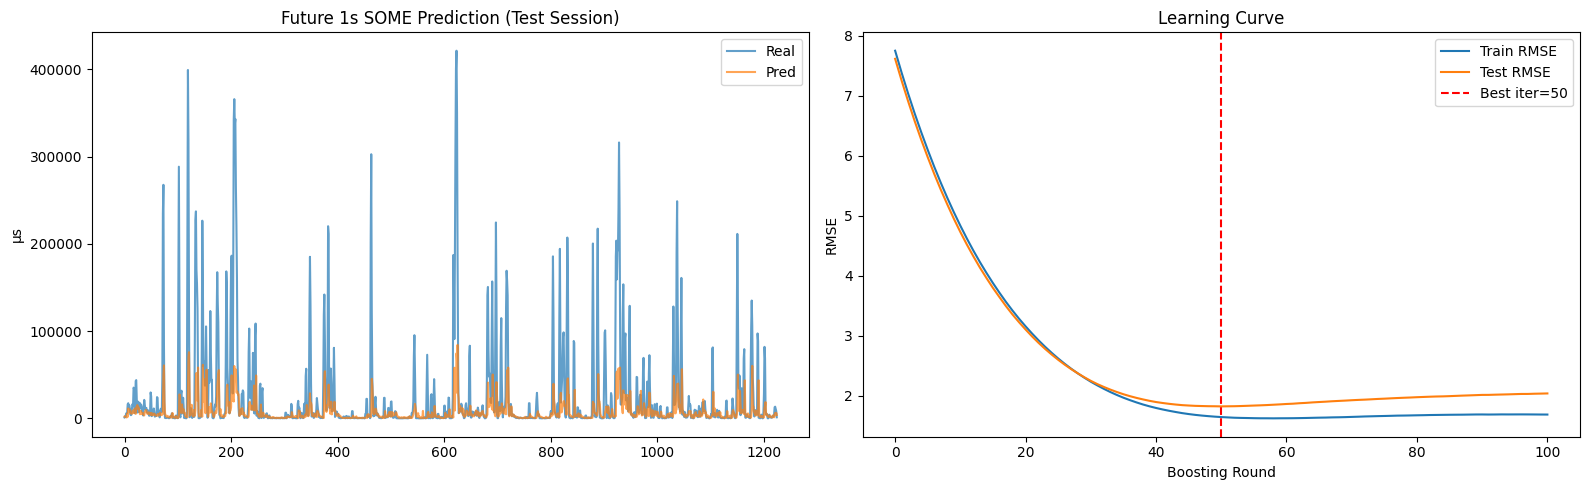

In [115]:
# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 左图：时序对比
axes[0].plot(y_real.values, label="Real", alpha=0.7)
axes[0].plot(pred_real, label="Pred", alpha=0.7)
axes[0].set_title("Future 1s SOME Prediction (Test Session)")
axes[0].legend()
axes[0].set_ylabel("μs")

# 右图：Early stopping 学习曲线
results = model.evals_result()
axes[1].plot(results['validation_0']['rmse'], label='Train RMSE')
axes[1].plot(results['validation_1']['rmse'], label='Test RMSE')
axes[1].axvline(model.best_iteration, color='r', linestyle='--', label=f'Best iter={model.best_iteration}')
axes[1].set_title("Learning Curve")
axes[1].legend()
axes[1].set_xlabel("Boosting Round")
axes[1].set_ylabel("RMSE")

plt.tight_layout()
plt.show()

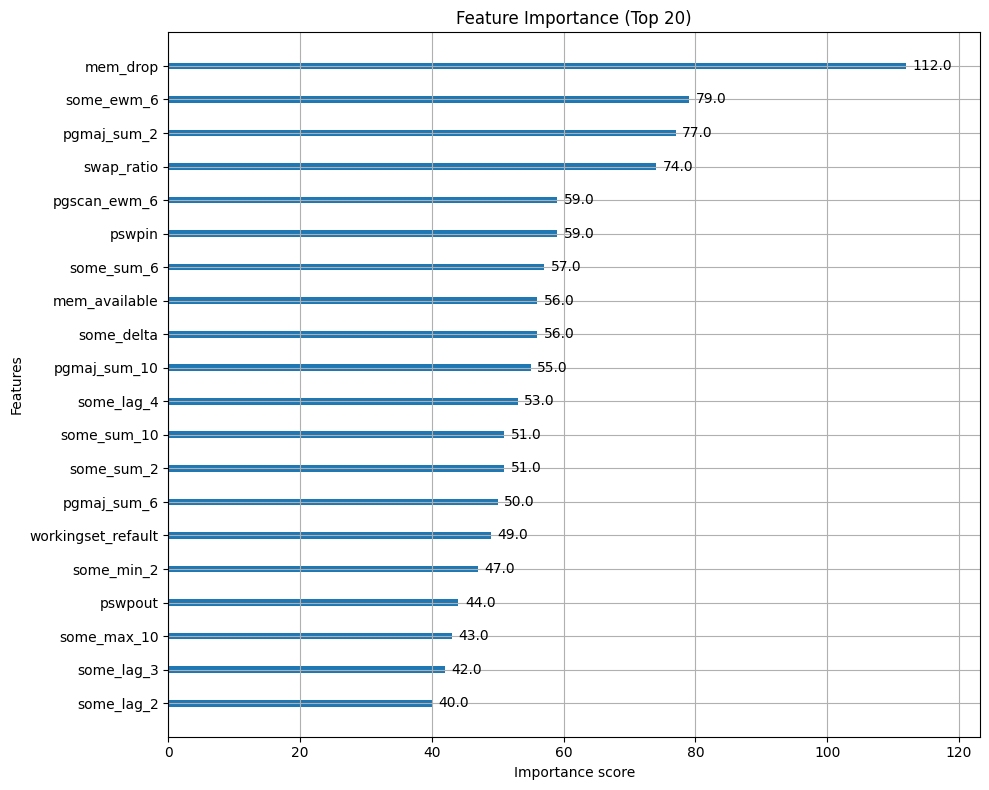

In [116]:
# 特征重要性（Top 20）
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=20, ax=ax)
plt.title("Feature Importance (Top 20)")
plt.tight_layout()
plt.show()